In [1]:
import os, warnings
import numpy as np
from pynq import allocate
from pynq import Overlay, PL, MMIO
from pynq import DefaultIP, DefaultHierarchy
from pynq import Xlnk
from pynq.xlnk import ContiguousArray
from pynq.lib import DMA
from cffi import FFI

from FilterBank import FilterBankDriver, StreamFilterDriver
from MultiplierHLS import MultiplierHLSDriver, StreamMultiplierHLSDriver
from Multiplier import MultiplierDriver, StreamMultiplierDriver
from MultiplierFP import MultiplierFPDriver, StreamMultiplierFPDriver
from MultiplierAXILite import MultiAXILiteDriver
from PDFPlotter import PDF

In [2]:
# Checking default overlay
if not os.path.exists(PL.bitfile_name):
    warnings.warn('There is no overlay loaded after boot.', UserWarning)
else:
    ol = Overlay(PL.bitfile_name)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: UserWarning: There is no overlay loaded after boot.
  This is separate from the ipykernel package so we can avoid doing imports until


# Loading overlay and showing info

In [3]:
PDF('./images/top_level.pdf',size=(1200,400))

In [4]:
PROJECT_FOLDER_PATH = os.path.dirname(os.path.realpath('__file__'))
OVERLAY_NAME = 'design_1.bit'
overlay = Overlay(os.path.join(PROJECT_FOLDER_PATH, OVERLAY_NAME))
# Checking if overlay is well loaded
print('PL bit file path %s' % PL.bitfile_name)
print('PL timestamp %s' % PL.timestamp)
if overlay.is_loaded():
    print('Overlay is loaded')
    overlay?
else:
    print('Overlay does not loaded')

PL bit file path /home/xilinx/jupyter_notebooks/AXI_interfaces/design_1.bit
PL timestamp 2020/6/26 12:18:54 +307053
Overlay is loaded


Type:            Overlay
String form:     <pynq.overlay.Overlay object at 0x7f849acc18>
File:            /usr/local/lib/python3.6/dist-packages/pynq/overlay.py
Docstring:      
Default documentation for overlay /home/xilinx/jupyter_notebooks/AXI_interfaces/design_1.bit. The following
attributes are available on this overlay:

IP Blocks
----------
filter_bank/filter_bank : FilterBank.FilterBankDriver
filter_bank/dma_filter_bank : pynq.lib.dma.DMA
multiplier_stream/multiplier : Multiplier.MultiplierDriver
multiplier_stream/dma_multiplier : pynq.lib.dma.DMA
mult_lite            : MultiplierAXILite.MultiAXILiteDriver
multiplier_fix_stream/multiplier_fix : MultiplierFP.MultiplierFPDriver
multiplier_fix_stream/dma_multiplier_fix : pynq.lib.dma.DMA
multiplier_hls_stream/multiplier_hls : MultiplierHLS.MultiplierHLSDriver
multiplier_hls_stream/dma_multiplier_hls : pynq.lib.dma.DMA

Hierarchies
-----------
filter_bank          : FilterBank.StreamFilterDriver
multiplier_hls_stream : MultiplierHLS

# Testing AXI Lite multiplier

In [5]:
print('AXI Lite A value %d\nAXI Lite B value %d\nAXI Lite Result value %d' % (overlay.mult_lite.a, overlay.mult_lite.b, overlay.mult_lite.result))
a = 735
b = 85700
print('Lets multiply %d by %d' % (a,b))
overlay.mult_lite.a = a
overlay.mult_lite.b = b
print('Obtained result is %d' % overlay.mult_lite.result)

AXI Lite A value 10
AXI Lite B value 2
AXI Lite Result value 20
Lets multiply 735 by 85700
Obtained result is 62989500


# Testing AXI Stream HLS multiplier
This hierarchy consists in DMA IP from the Xilinx IP catalog and Multiplier IP from HLS. Following image shows the IP Integrator schema

In [6]:
PDF('./images/multiplier_hls_stream.pdf',size=(900,300))

Following HLS code for **multiplier_hls** IP is shown:
```c
#include <stdlib.h>
#include <stdio.h>
#include <ap_int.h>
#include <ap_fixed.h>
#include <ap_axi_sdata.h>

typedef ap_axis<32,1,1,1> stream_type;

void multiplier_HLS(stream_type* in_data, stream_type* out_data, ap_int<32> constant)
{
#pragma HLS INTERFACE s_axilite register port=constant
#pragma HLS INTERFACE ap_ctrl_none port=return
#pragma HLS INTERFACE axis port=in_data
#pragma HLS INTERFACE axis port=out_data
    out_data->data = in_data->data * constant;
    out_data->dest = in_data->dest;
    out_data->id = in_data->id;
    out_data->keep = in_data->keep;
    out_data->last = in_data->last;
    out_data->strb = in_data->strb;
    out_data->user = in_data->user;
}
```
And also, following image shows the DMA IP configuration:


<img src="./images/dma_multiplier_hls.PNG" width="800" height="650"/>

In [7]:
dma_mult_hls = overlay.multiplier_hls_stream.dma_multiplier_hls
mult_hls = overlay.multiplier_hls_stream.multiplier_hls

In [8]:
xlnk = Xlnk()
length = 1024 # this is the maximum size for transfer buffer
in_buffer = xlnk.cma_array(shape=(length,), dtype=np.uint32, cacheable=1)
out_buffer = xlnk.cma_array(shape=(length,), dtype=np.uint32, cacheable=1)
for i in range(length):
    in_buffer[i] = i
mult_hls.constant = 100

In [9]:
dma_mult_hls.sendchannel.transfer(in_buffer)
dma_mult_hls.sendchannel.wait()

In [10]:
dma_mult_hls.recvchannel.transfer(out_buffer)
dma_mult_hls.recvchannel.wait()

print(out_buffer)
xlnk.xlnk_reset()

[     0    100    200 ... 102100 102200 102300]


In [11]:
length = 512
in_buffer = xlnk.cma_array(shape=(length,), dtype=np.uint32)
for i, v, in enumerate(np.arange(length)):
    in_buffer[i] = 2*v

out_buffer = xlnk.cma_array(shape=(length,), dtype=np.uint32)
overlay.multiplier_hls_stream.stream_multiply(in_buffer, out_buffer, 3)
print(out_buffer)
xlnk.xlnk_reset()

[   0    6   12   18   24   30   36   42   48   54   60   66   72   78
   84   90   96  102  108  114  120  126  132  138  144  150  156  162
  168  174  180  186  192  198  204  210  216  222  228  234  240  246
  252  258  264  270  276  282  288  294  300  306  312  318  324  330
  336  342  348  354  360  366  372  378  384  390  396  402  408  414
  420  426  432  438  444  450  456  462  468  474  480  486  492  498
  504  510  516  522  528  534  540  546  552  558  564  570  576  582
  588  594  600  606  612  618  624  630  636  642  648  654  660  666
  672  678  684  690  696  702  708  714  720  726  732  738  744  750
  756  762  768  774  780  786  792  798  804  810  816  822  828  834
  840  846  852  858  864  870  876  882  888  894  900  906  912  918
  924  930  936  942  948  954  960  966  972  978  984  990  996 1002
 1008 1014 1020 1026 1032 1038 1044 1050 1056 1062 1068 1074 1080 1086
 1092 1098 1104 1110 1116 1122 1128 1134 1140 1146 1152 1158 1164 1170
 1176 

# Testing AXI Stream multiplier
This hierarchy consists in DMA IP from the Xilinx IP catalog and Multiplier IP from System Generator. Following image shows the IP Integrator schema

In [12]:
PDF('./images/multiplier_stream.pdf',size=(900,300))

The IP multiplier is generated with the Systen Generator as follows:

<img src="./images/multiplier_sysgen.PNG" width="1200" height="700"/>

And also, following image shows the DMA IP configuration:

<img src="./images/dma_multiplier.PNG" width="800" height="650"/>

In [13]:
xlnk = Xlnk()
length = 4
#stream = [0,20.5,3,50]
in_buffer = xlnk.cma_array(shape=(length,), dtype=np.uint32, cacheable=1)
for i, v, in enumerate(np.arange(length)):
    in_buffer[i] = v

out_buffer = xlnk.cma_array(shape=(length,), dtype=np.uint32, cacheable=1)
overlay.multiplier_stream.stream_multiply(in_buffer, out_buffer, 50)
print(out_buffer)
xlnk.xlnk_reset()

[  0  50 100 150]


#### Testing
Limit is 64

In [14]:
length = 5
in_buffer = xlnk.cma_array(shape=(length,), dtype=np.uint32, cacheable=1)
out_buffer = xlnk.cma_array(shape=(length,), dtype=np.uint32, cacheable=1)
for i in range(length):
    in_buffer[i] = i

In [ ]:
overlay.multiplier_stream.dma_multiplier.sendchannel.transfer(in_buffer)
overlay.multiplier_stream.dma_multiplier.sendchannel.wait()

In [ ]:
overlay.multiplier_stream.dma_multiplier.recvchannel.transfer(out_buffer)
overlay.multiplier_stream.dma_multiplier.recvchannel.wait()
print(out_buffer)
xlnk.xlnk_reset()

# Testing AXI Stream fixed point multiplier

In [15]:
xlnk = Xlnk()

stream = [0,20.5,3,50]
in_buffer = xlnk.cma_array(shape=(len(stream),), dtype=np.uint16)
for i, v, in enumerate(stream):
    in_buffer[i] = v

out_buffer = xlnk.cma_array(shape=(len(stream),), dtype=np.uint32)
overlay.multiplier_fix_stream.stream_multiply(in_buffer, out_buffer, 30)

In [16]:
from fxpmath import Fxp
x = Fxp(0.75, signed=True, n_word=16, n_frac=14)
x.info(verbose=3)

	dtype		=	fxp-s16/14
	Value		=	0.75

	Signed		=	True
	Word bits	=	16
	Fract bits	=	14
	Int bits	=	1
	Val data type	=	float64

	Upper		=	1.99993896484375
	Lower		=	-2.0
	Precision	=	6.103515625e-05
	Overflow	=	saturate
	Rounding	=	trunc
	Shifting	=	expand



In [17]:
print('Fixed point value x stored in memory: %d' % x.val)
print('Fixed point value x in binary: %s' % x.bin(frac_dot=True))
in_buffer[0] = x.val
overlay.multiplier_fix_stream.stream_multiply(in_buffer, out_buffer, 5)
out_buffer

Fixed point value x stored in memory: 12288
Fixed point value x in binary: 00.11000000000000


PynqBuffer([245760,    400,     60,   1000], dtype=uint32)

In [18]:
print('Result in binary %s'%"{0:b}".format(out_buffer[0]))

Result in binary 111100000000000000


In [19]:
result = Fxp(0.0, signed=False, n_word=32, n_frac=16)
result('0b'+'{0:b}'.format(out_buffer[0])).info(verbose=3)
xlnk.xlnk_reset()

	dtype		=	fxp-u32/16
	Value		=	3.75

	Signed		=	False
	Word bits	=	32
	Fract bits	=	16
	Int bits	=	16
	Val data type	=	float64

	Upper		=	65535.99998474121
	Lower		=	0.0
	Precision	=	1.52587890625e-05
	Overflow	=	saturate
	Rounding	=	trunc
	Shifting	=	expand



# Testing AXI Stream fixed point filter bank
## Creating input signal in fixed point 16_14

In [20]:
from h5py import File
import os

filename = 'signal_fxp.h5'
save = False
overwrite = True

if overwrite | (not os.path.exists(filename)):
    # Signal parameters
    n_samples = 4
    sampling_rate = 100e6
    t_ini = 0
    t_end = n_samples/sampling_rate
    #t_end = 0.00000125
    sampling_rate = sampling_rate
    f1  = 20e6;
    f2  = 40e6;
    # Time vector generation
    time = np.arange(t_ini,t_end,1/sampling_rate)
    # Signals generation
    amp = 1;
    signal_float64 = amp*(np.sin(2*np.pi*f1*time) + np.sin(2*np.pi*f2*time))
    # Converting signal to fixed point data
    signal_fxp = Fxp(signal_float64, signed=True, n_word=16, n_frac=14)
    
    if save:
        with File(filename, 'w') as f:
            main_group = f.create_group(np.string_('SIGNAL_FXP_16_14'))
            main_group.attrs.create(np.string_('SIGNAL@SAMPLE_RATE'), np.int32(sampling_rate))
            main_group.attrs.create(np.string_('FIXED_POINT@SIGNED'), np.bool(True))
            main_group.attrs.create(np.string_('FIXED_POINT@N_BITS'), np.uint8(16))
            main_group.attrs.create(np.string_('FIXED_POINT@DECIMAL'), np.uint8(14))
            main_group.create_dataset('TIME', data=time, dtype=np.float64)
            main_group.create_dataset('SIGNAL_FXP', data=signal_fxp.val, dtype=np.int16)
            main_group.create_dataset('SIGNAL_FLOAT64', data=signal_float64, dtype=np.float64)
else:
    pass

In [21]:
signal_fxp[:30]

array([ 0.        ,  1.53881836, -0.36322021,  0.36322021])

In [22]:
import matplotlib.pyplot as plt

n_samples_to_plot = 30
plt.plot(time[:n_samples_to_plot],signal_fxp[:n_samples_to_plot])
plt.plot(time[:n_samples_to_plot],signal_float64[:n_samples_to_plot])
plt.legend(['Fixed point 16_14','Float64'])
plt.show()

In [23]:
in_signal = xlnk.cma_array(shape=(len(signal_float64),), dtype=np.uint16)
for idx, value, in enumerate(signal_fxp.val):
    in_signal[idx] = value

In [24]:
out_signal = xlnk.cma_array(shape=(len(signal_float64),), dtype=np.uint32)
#overlay.filter_bank.stream_filter(in_buffer, out_buffer, 0)
overlay.filter_bank.stream_filter(in_signal, out_signal, 2)

In [25]:
output_key0 = Fxp(np.zeros(len(signal_float64)), signed=False, n_word=32, n_frac=28)

In [26]:
for idx, value in enumerate(out_signal):
    output_key0.val[idx] = value

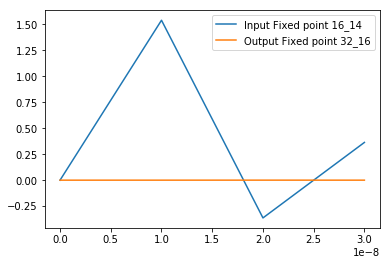

In [27]:
n_samples_to_plot = 60
plt.plot(time[:n_samples_to_plot],signal_fxp[:n_samples_to_plot])
plt.plot(time[:n_samples_to_plot],output_key0[:n_samples_to_plot])
plt.legend(['Input Fixed point 16_14','Output Fixed point 32_16'])
plt.show()

In [28]:
output_key0.val

array([    0, 25212, 59585,  5951], dtype=uint64)

In [29]:
out_signal

PynqBuffer([    0, 25212, 59585,  5951], dtype=uint32)

In [58]:
in_signal

PynqBuffer([    0, 25212, 59585], dtype=uint16)